In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import cv2, os, keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,MaxPool2D,Dropout
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow

In [ ]:
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
train_path = "/content/gdrive/My Drive/Dog vs Cat/train"
test_path = "/content/gdrive/My Drive/Dog vs Cat/test"
class_names = os.listdir(train_path)
class_names_test = os.listdir(test_path)

print(class_names)

['Dog', 'Cat']


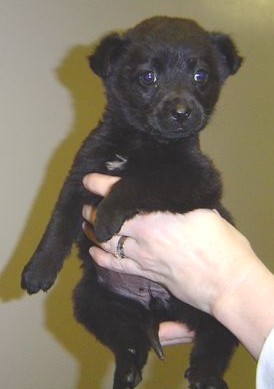

In [ ]:
image_dog=cv2.imread("/content/gdrive/My Drive/Dog vs Cat/train/Dog/200.jpg")
cv2_imshow(image_dog)

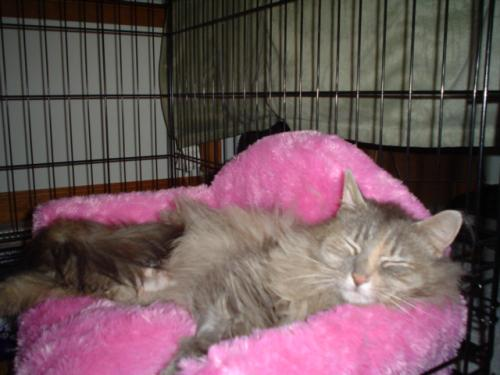

In [ ]:
image_cat=cv2.imread("/content/gdrive/My Drive/Dog vs Cat/train/Cat/120.jpg")
cv2_imshow(image_cat)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15, rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/gdrive/My Drive/Dog vs Cat/train",
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory("/content/gdrive/My Drive/Dog vs Cat/test",
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  shuffle=False,
                                                  class_mode='binary')

Found 22044 images belonging to 2 classes.
Found 3010 images belonging to 2 classes.


In [ ]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16_last_conv'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    return model

In [ ]:
model=VGG16()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [ ]:
Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16_last_conv').output)
Vgg16.load_weights("/content/gdrive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

for layer in Vgg16.layers:
    layer.trainable = False

In [ ]:
opt = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

mc = ModelCheckpoint('/content/gdrive/My Drive/best_model_weights.h5', monitor='val_accuracy', mode='max', save_best_only=True)

H = model.fit(train_generator, validation_data=test_generator, epochs=20, verbose=1, callbacks=[mc,es])

Epoch 1/20
178/689 [======>.......................] - ETA: 3:05:13 - loss: 0.5747 - accuracy: 0.7356

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_generator)

 6/95 [>.............................] - ETA: 23:11 - loss: 0.3456 - accuracy: 0.9635

KeyboardInterrupt: ignored